In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pymorphy3
import mlflow

from nltk.corpus import stopwords
from tqdm.auto import tqdm
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

## Предобработка текстов

In [2]:
aeroflot = pd.read_csv('../data/raw/aeroflot_official_posts.csv')
aviatorshina = pd.read_csv('../data/raw/aviatorshina_posts.csv')
favt = pd.read_csv('../data/raw/favt_ru_posts.csv')
s7 = pd.read_csv('../data/raw/s7newsroom_posts.csv')

**Объединие данных из каналов в один датафрейм**

In [3]:
df = pd.concat([aeroflot, aviatorshina, favt, s7], axis=0)
df.head()

,message
0,❄️ Только представьте: полёт в сопровождении о...
1,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...
2,В законодательстве РФ изменились правила выезд...
3,🛜 Прокачали навыки нашего чат-бота и подарили ...
4,Связали две столицы с помощью нейросети Аэрофл...


In [4]:
len(df)

7494

**Удаление пустых значений**

In [5]:
df.isnull().sum()

message    3823
dtype: int64

In [6]:
df = df.dropna()

In [7]:
len(df)

3671

**Обработка дубликатов**

In [8]:
np.sum(df.duplicated())

np.int64(2)

In [9]:
df[df.duplicated]

,message
1852,Актуальные новости мира БАС: В Беларуси физлиц...
1593,#Мнение_экспертов — старшего научного сотрудни...


In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
len(df)

3669

**Анализ длин постов**

In [12]:
df['message_lenght'] = df['message'].apply(lambda x: len(x))
df['word_count'] = df['message'].str.split().str.len()

Text(0.5, 0, 'messages_lenght')

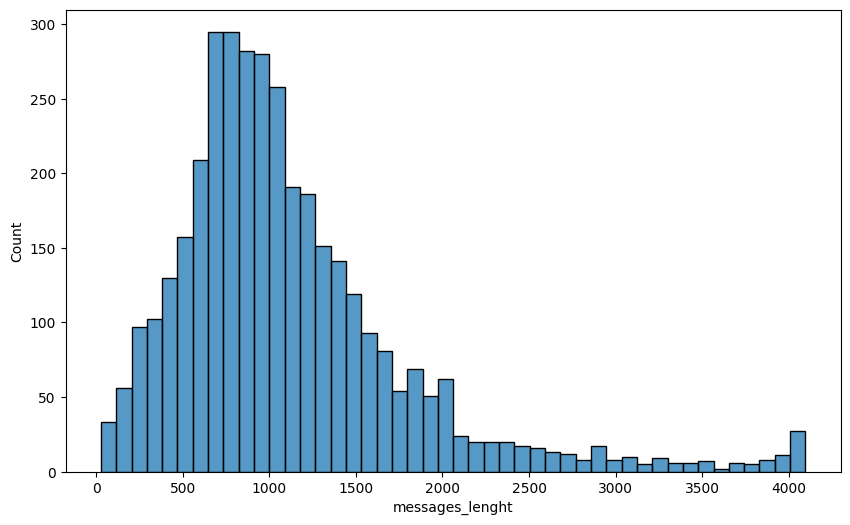

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['message_lenght'])
plt.xlabel("messages_lenght")

Text(0.5, 0, 'Count of words')

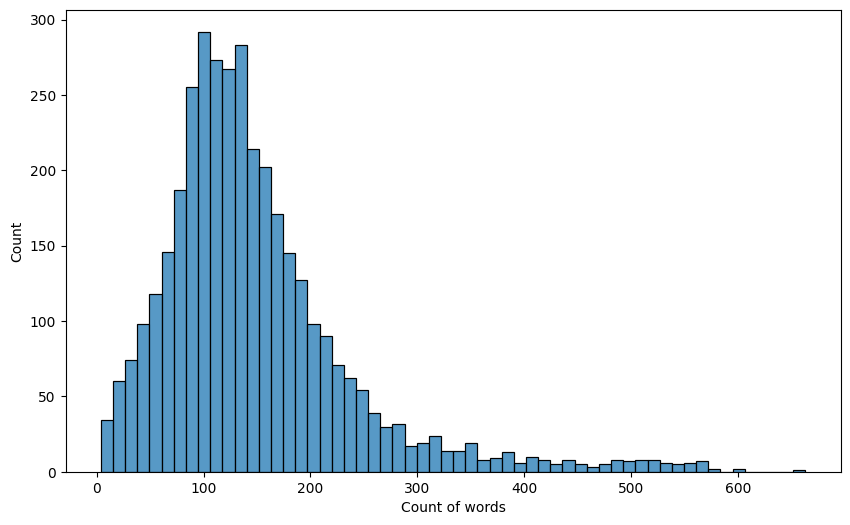

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(x=df['word_count'])
plt.xlabel("Count of words")

**Удалим слишком короткие и слишком длинные сообщения**

In [15]:
filtered_df = df[df['word_count'] <= 400].copy()

filtered_df = filtered_df[
    (filtered_df['message_lenght']) >= 20 & 
    (filtered_df['message_lenght'] <= 2000)
]
    
print(f"После фильтрации: {len(filtered_df)} сообщений")
print(f"Удалено: {len(df) - len(filtered_df)} сообщений")

После фильтрации: 3564 сообщений
Удалено: 105 сообщений


**Предобработка текстов**

In [16]:
# создаём морфологический анализатор
morph = pymorphy3.MorphAnalyzer()

if 'russian_stopwords' not in locals():
      russian_stopwords = stopwords.words("russian")

texts_as_lists = []

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower() # Приведение к нижнему регистру
        text = text.lower()
        text = re.sub(r'[^а-яё]', ' ', text) # Удаление пунктуации, кроме пробелов
        # разбиваем на слова
        words = text.split()
        # приводим к леммам, убираем стоп-слова и короткие слова (это важно для тематическго моделирования)
        lemmas = [morph.parse(word)[0].normal_form for word in words if word not in russian_stopwords and len(word) > 2]
        texts_as_lists.append(lemmas)
        return " ".join(lemmas)
    return "" # Возвращаем пустую строку для нестроковых значений


print("\nНачало предобработки текста...")
# Применение предобработки к столбцу с текстом. Используем tqdm для отслеживания прогресса.
if 'message' in filtered_df.columns:
    tqdm.pandas()
    filtered_df['processed_text'] = filtered_df['message'].progress_apply(preprocess_text)
    print("Предобработка текста завершена.")
    display(filtered_df.head())


Начало предобработки текста...


100%|██████████| 3564/3564 [00:17<00:00, 203.67it/s]

Предобработка текста завершена.


,message,message_lenght,word_count,processed_text
0,❄️ Только представьте: полёт в сопровождении о...,603,83,представить полёт сопровождение оркестр борт р...
1,✈️✈️✈️✈️✈️✈️✈️✈️\n🎁 Пока вы составляете список...,943,186,пока составлять список подарок новогодний праз...
2,В законодательстве РФ изменились правила выезд...,943,134,законодательство измениться правило выезд неко...
3,🛜 Прокачали навыки нашего чат-бота и подарили ...,727,103,прокачать навык наш чат бот подарить новый суп...
4,Связали две столицы с помощью нейросети Аэрофл...,860,131,связать два столица помощь нейросеть аэрофлот ...


In [31]:
texts = filtered_df['processed_text']

**Облако слов**

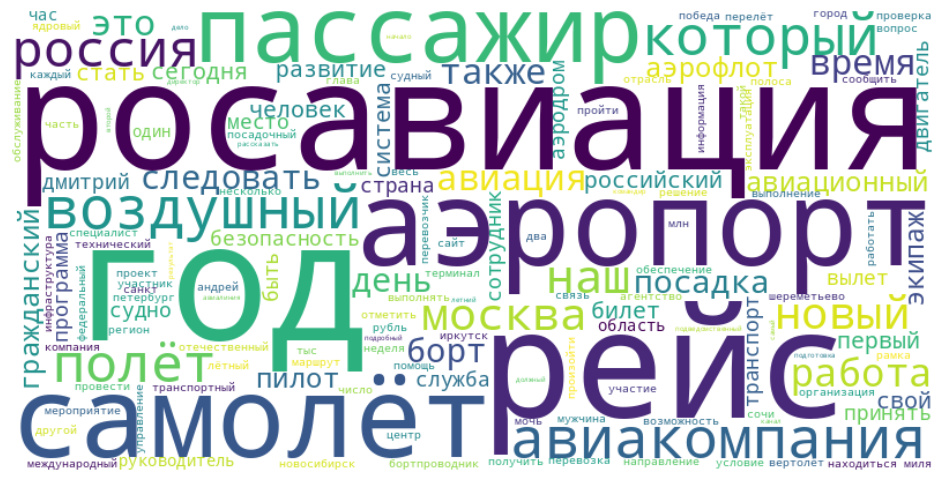

In [ ]:
def create_wordcloud(texts, max_words=100):
    all_text = ' '.join(texts)
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        collocations=False
    ).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return wordcloud


wordcloud = create_wordcloud(filtered_df['processed_text'], max_words=150)

## Обучение моделей

### LDA

In [ ]:
def train_lda_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение LDA модели
    """
    # Векторизация текстов
    vectorizer = CountVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=random_state,
        max_iter=10,
        learning_method='online'
    )
    
    lda.fit(X)
    
    # Отображение топ-слов для каждой темы
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
        print(f"Тема #{topic_idx + 1}:", top_words)
    
    return lda, vectorizer

In [77]:
experiment = mlflow.create_experiment(name="topic_modeling", artifact_location='my-artifacts')

In [90]:
lda_models = []

def experiment_lda_with_mlflow(texts, n_topics_list=[5, 10, 15]):
    """
    Проведение экспериментов с разным количеством тем
    """
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment, run_name=f"LDA_{n_topics}_topics"):
            # Логируем параметры
            mlflow.log_param("model_type", "LDA")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("max_features", 1000)
            
            # Обучаем модель
            lda, vectorizer = train_lda_model(texts, n_topics=n_topics)
            lda_models.append(lda)
            print(f"✅ Эксперимент с {n_topics} темами завершен")
            print("-" * 50)


def log_topics_to_mlflow(lda_model, feature_names, n_words=10, filename="topics.txt"):
    """Сохраняет топ-слов тем в файл и логирует в MLflow"""
    
    topics_text = "Топ-слова для каждой темы:\n\n"
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics_text += f"Тема #{topic_idx + 1}: "
        topics_text += ", ".join(top_words) + "\n\n"
    
    # Сохраняем в временный файл
    with open(filename, "w", encoding="utf-8") as f:
        f.write(topics_text)
    
    # Логируем как артефакт
    mlflow.log_artifact(filename)
    
    return topics_text

In [91]:
experiment_lda_with_mlflow(texts, n_topics_list=[5, 10, 15])

Размер матрицы: (3564, 2000)
Количество тем: 5
Тема #1: ['наш', 'день', 'который', 'год', 'новый']
Тема #2: ['росавиация', 'год', 'россия', 'авиация', 'воздушный']
Тема #3: ['самолёт', 'посадка', 'борт', 'экипаж', 'пилот']
Тема #4: ['рейс', 'москва', 'новосибирск', 'билет', 'направление']
Тема #5: ['аэропорт', 'авиакомпания', 'пассажир', 'рейс', 'воздушный']
✅ Эксперимент с 5 темами завершен
--------------------------------------------------
🏃 View run LDA_5_topics at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/26be282179764143ad30d113df085c6c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694
Размер матрицы: (3564, 2000)
Количество тем: 10
Тема #1: ['новый', 'путешествие', 'наш', 'который', 'класс']
Тема #2: ['который', 'самолёт', 'свой', 'бортпроводник', 'пилот']
Тема #3: ['наш', 'день', 'авиация', 'страна', 'праздник']
Тема #4: ['самолёт', 'посадка', 'борт', 'экипаж', 'пилот']
Тема #5: ['воздушный', 'росавиация', 'полёт', 'безопасность', 'в

In [93]:
lda_models

[LatentDirichletAllocation(learning_method='online', n_components=5,
                           random_state=42),
 LatentDirichletAllocation(learning_method='online', random_state=42),
 LatentDirichletAllocation(learning_method='online', n_components=15,
                           random_state=42)]

In [97]:
with mlflow.start_run(experiment_id=experiment, run_name=f"LDA_best_model"):
    mlflow.sklearn.log_model(lda_models[1], "lda_model")

2025/11/28 05:36:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/11/28 05:36:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 05:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LDA_best_model at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/e9915a539f2f4500828410cd6fcbf30e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694


### NMF

In [85]:
def train_nmf_model(texts, n_topics=10, max_features=2000, random_state=42):
    """
    Обучение NMF модели
    """
    # Векторизация текстов с TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words=russian_stopwords
    )
    
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"Размер матрицы: {X.shape}")
    print(f"Количество тем: {n_topics}")
    
    # Обучение NMF
    nmf = NMF(
        n_components=n_topics,
        random_state=random_state,
        max_iter=200,
        init='nndsvda'
    )
    
    nmf.fit(X)
    
    # Отображение топ-слов для каждой темы
    for topic_idx, topic in enumerate(nmf.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
        print(f"Тема #{topic_idx + 1}:", top_words)
    
    return nmf, vectorizer

In [98]:
nmf_models = []

def experiment_nmf_with_mlflow(texts, n_topics_list=[5, 10, 15]):
    """
    Проведение экспериментов с разным количеством тем для NMF
    """
    for n_topics in n_topics_list:
        with mlflow.start_run(experiment_id=experiment, run_name=f"NMF_{n_topics}_topics"):
            # Логируем параметры
            mlflow.log_param("model_type", "NMF")
            mlflow.log_param("n_topics", n_topics)
            mlflow.log_param("max_features", 1000)
            mlflow.log_param("vectorizer", "TF-IDF")
            
            # Обучаем модель
            nmf, vectorizer = train_nmf_model(texts, n_topics=n_topics)
            
            # Логируем топ-слова
            log_topics_to_mlflow(nmf, vectorizer.get_feature_names_out(), n_words=15, filename=f"nmf_topics_{n_topics}.txt")
            nmf_models.append(nmf)

            print(f"✅ NMF эксперимент с {n_topics} темами завершен")
            print("-" * 50)


In [100]:
# Запуск экспериментов NMF
experiment_nmf_with_mlflow(texts, n_topics_list=[5, 10, 15])

Размер матрицы: (3564, 2000)
Количество тем: 5
Тема #1: ['самолёт', 'посадка', 'борт', 'экипаж', 'пилот']
Тема #2: ['росавиация', 'авиация', 'гражданский', 'наш', 'россия']
Тема #3: ['москва', 'рейс', 'билет', 'новосибирск', 'иркутск']
Тема #4: ['год', 'аэропорт', 'развитие', 'новый', 'дмитрий']
Тема #5: ['аэропорт', 'рейс', 'пассажир', 'авиакомпания', 'аэрофлот']
✅ NMF эксперимент с 5 темами завершен
--------------------------------------------------
🏃 View run NMF_5_topics at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/ad89e14d560340718bafb67c5bdd17c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694
Размер матрицы: (3564, 2000)
Количество тем: 10
Тема #1: ['самолёт', 'посадка', 'пилот', 'двигатель', 'экипаж']
Тема #2: ['росавиация', 'авиация', 'авиационный', 'гражданский', 'дмитрий']
Тема #3: ['рейс', 'москва', 'новосибирск', 'иркутск', 'направление']
Тема #4: ['аэропорт', 'новый', 'терминал', 'реконструкция', 'инфраструктура']
Тема #5: ['

In [101]:
nmf_models

[NMF(init='nndsvda', n_components=5, random_state=42),
 NMF(init='nndsvda', n_components=10, random_state=42),
 NMF(init='nndsvda', n_components=15, random_state=42)]

In [102]:
with mlflow.start_run(experiment_id=experiment, run_name=f"NMF_best_model"):
    mlflow.sklearn.log_model(nmf_models[2], "nmf_model")

2025/11/28 05:48:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 05:48:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/11/28 05:48:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run NMF_best_model at: http://127.0.0.1:5000/#/experiments/307744178423469694/runs/b6e64a39727d49ea812b9601c7af555a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/307744178423469694
